In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt
import _pickle as cPickle
import scipy.io
import scipy as sp
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import distance
import json, sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
def pickle_dump(fn, data):
    with open(fn, "wb") as output_file:
        cPickle.dump(data, output_file)
        
def pickle_load(fn):
    with open(fn, "rb") as input_file:
        data = cPickle.load(input_file)
    return data

In [3]:
folder = 'cnn3'

def run_cnn(size, patches, sparse_codes, dic):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(filters=size, kernel_size=8, activation='relu', input_shape=(8,8,3)))
    model.add(Flatten())
    # model.add(Dense(size, activation='relu'))
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    model.summary()
    history = model.fit(patches, sparse_codes, epochs=1000, verbose=0)
    
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('{}/cnn_{}_loss.png'.format(folder, size))
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()

    # Reconstruct
    pred_codes = model.predict(patches)
    recon = np.dot(pred_codes, dic.T)
    recon = recon.reshape(len(pred_codes), 8 , 8, 3)
    patches_true = patches.reshape(patches.shape[0], 8, 8, 3)

    # Generate plot
    f, axarr = plt.subplots(2, 10)
    f.set_size_inches(20, 5)
    for i in range(10):
        axarr[0,i].imshow((recon[i]+0.5).astype('float64'))
        axarr[1,i].imshow((patches_true[i]+0.5).astype('float64'))
    plt.suptitle("First 10 cifar_patch reconstructions\n(Complete, {} element dictionary)".format(size))
    # plt.show()
    plt.savefig('{}/cnn_{}_cifar_patch_reconstruction.png'.format(folder, size))
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    plt.figure(figsize = (4, 4))
    for i, patch in enumerate(recon[:16,:,:,:]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((patch+0.5).astype('float64'))
    plt.subplots_adjust(0.05)
    plt.figure(figsize = (4, 4))
    for i, patch in enumerate(patches_true[:16,:,:,:]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((patch+0.5).astype('float64'))
    plt.subplots_adjust(0.05)
    
    # Visualize Learned Filters
    for layer in model.layers:
        # check for convolutional layer
        if 'conv' in layer.name:
            # get filter weights
            filters, biases = layer.get_weights()
            print(layer.name, filters.shape)

    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)


    # Plot first 100 elements of learned filters
    plt.figure(figsize=(8, 8))
    for i in range(100):
        plt.subplot(8,16, i + 1)
        plt.imshow(filters[:,:,:,i].astype('float32'))#, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('{} elements of learned filters\n'.format(size), fontsize=12)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.87, 0.08, 0.23)
    # plt.show()
    plt.savefig('{}/cnn_{}_learned_filters.png'.format(folder, size))
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    
    # Extract idx
    patch = patches
    true_codes = sparse_codes

    # Compute comparison
    comparison = {}
    comparison['cosine'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'cosine')))
    comparison['correlation'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'correlation')))
    comparison['manhattan'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'cityblock')))
    comparison['euclidean'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'euclidean')))
    comparison['hamming'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'hamming')))
    comparison['hamming2'] = np.mean(np.diag(distance.cdist(true_codes, pred_codes, 'hamming')))
    # comparison['dice'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'dice'))) # Dice dissimilarity
    # comparison['jaccard'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'jaccard'))) # Jaccard-Needham dissimilarity
    # comparison['kulsinski'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'kulsinski'))) # Kulsinski dissimilarity
    # comparison['rogerstanimoto'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'rogerstanimoto'))) # Rogers-Tanimoto dissimilarity
    # comparison['russellrao'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'russellrao'))) # Russell-Rao dissimilarity
    # comparison['sokalmichener'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'sokalmichener'))) # Sokal-Michener dissimilarity
    # comparison['sokalsneath'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'sokalsneath'))) # Sokal-Sneath dissimilarity
    # comparison['yule'] = np.nanmean(np.diag(distance.cdist(true_codes, pred_codes, 'yule'))) # Yule dissimilarity
    # print(comparison)
    with open('{}/cnn_{}_code_comparison_results.json'.format(folder, size), 'w', encoding='utf-8') as f:
        json.dump(comparison, f, ensure_ascii=False, indent=4)
        
    for m in range(10):
        plt.figure(figsize=(10, 5))
        # # print(distance.cdist(sparse_codes[0], pred_codes[0], 'hamming'))
        # print(distance.hamming(sparse_codes[0], pred_codes[0])*len(sparse_codes[0]))
        # print(sparse_codes[0])
        # print(pred_codes[0])
        x = np.arange(len(sparse_codes[0]))
        plt.subplot(311, title = 'LCA vs. ANN predicted code: {} element dictionary'.format(size)).axhline(y=0, color = 'black')
        plt.bar(x - 0.2, sparse_codes[m], color='b', width=.4, label = 'LCA')
        plt.bar(x + 0.2, pred_codes[m], color='r', width=.4, label = 'CNN')
        plt.legend()
        # plt.show()
        plt.savefig('{}/cnn_{}_activation_{}.png'.format(folder, size, m))
        plt.figure().clear()
        plt.close()
        plt.cla()
        plt.clf()

2022-01-20 15:21:14.687351: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-20 15:21:14.722677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-01-20 15:21:14.722934: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-20 15:21:14.724995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-20 15:21:14.726858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-20 15:21:14.727171: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1, 128)         24704     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
Total params: 24,704
Trainable params: 24,704
Non-trainable params: 0
_________________________________________________________________


2022-01-20 15:21:15.669143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-20 15:21:16.417875: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with

conv2d (8, 8, 3, 128)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 256)         49408     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
Total params: 49,408
Trainable params: 49,408
Non-trainable params: 0
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

conv2d_1 (8, 8, 3, 256)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1, 512)         98816     
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
Total params: 98,816
Trainable params: 98,816
Non-trainable params: 0
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

conv2d_2 (8, 8, 3, 512)


<Figure size 432x288 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

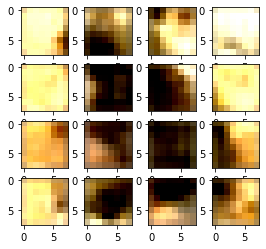

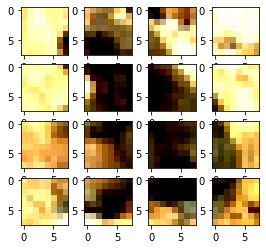

<Figure size 576x576 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

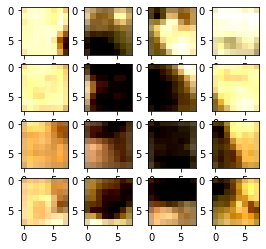

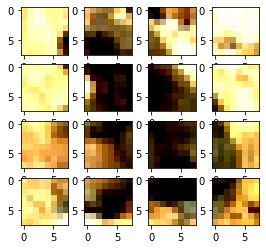

<Figure size 576x576 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

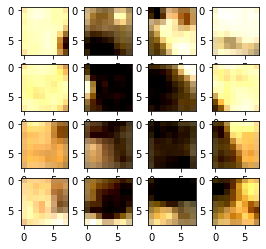

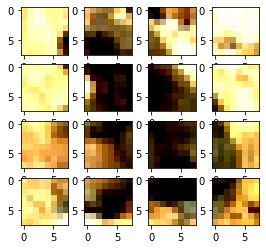

<Figure size 576x576 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [4]:
for size in [128, 256, 512]:
    limit = 1000
    patches = pickle_load('patches.pkl')[:limit,:,:,:]
    sparse_codes = pickle_load('codes{}_1000.pkl'.format(size))
    dic = pickle_load('dic_{}.pkl'.format(size))
    run_cnn(size, patches, sparse_codes, dic)